In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data Description These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in yyyy-mm-dd format The local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

1. Solar radiation: watts per meter^2
2. Temperature: degrees 
3. Fahrenheit Humidity: percent 
4. Barometric pressure: Hg 
5. Wind direction: degrees 
6. Wind speed: miles per hour 
7. Sunrise/sunset: Hawaii time 
8. Link: https://www.kaggle.com/datasets/dronio/SolarEnergy

<font color = 'green' size = '6'>Table of Content</font>
1. Importing Libraries
2. Loading Data 
3. Data Wrangling 
4. Feature Selection using Correlation Matrix 
5. Feature Selection using SelectKBest Method 
6. Feature Selection using Extra Tree Classifier 
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation 
8. Preparing data - Standardisation and Splitting 
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction 

**1) Importing Libraries**

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt

import re

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
import xgboost as xb

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

**2) Loading Data**

In [6]:
data = pd.read_csv('/kaggle/input/solarprediction/SolarPrediction.csv')
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


**3) Data Wrangling**

In [8]:
df = data.copy()
df['Data'] = df['Data'].apply(lambda x: x.split()[0])
df['Data']

0        9/29/2016
1        9/29/2016
2        9/29/2016
3        9/29/2016
4        9/29/2016
           ...    
32681    12/1/2016
32682    12/1/2016
32683    12/1/2016
32684    12/1/2016
32685    12/1/2016
Name: Data, Length: 32686, dtype: object

**3) Data Wrangling**

In [9]:
df['Year'] = pd.to_datetime(df['Data']).dt.year
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Year,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016,9,29,23,35,24


In [10]:
df['Year'].unique()

array([2016], dtype=int32)

In [11]:
df['risehour'] = pd.to_datetime(df['TimeSunRise']).dt.hour
df['riseminute'] = pd.to_datetime(df['TimeSunRise']).dt.minute
df['sethour'] = pd.to_datetime(df['TimeSunSet']).dt.hour
df['setminute'] = pd.to_datetime(df['TimeSunSet']).dt.minute
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,...,Year,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,...,2016,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,...,2016,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,...,2016,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,...,2016,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,...,2016,9,29,23,35,24,6,13,18,13


In [12]:
# extract the sunrise and sunset information using regular expression
# df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
# df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

# df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
# df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)
# df.head()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Year                    32686 non-null  int32  
 12  Month                   32686 non-null  int32  
 13  Day                     32686 non-null  int32  
 14  Hour                    32686 non-null

In [14]:
df.drop(['UNIXTime', 'Data', 'Time','TimeSunRise', 'TimeSunSet', 'Year'], axis = 1, inplace = True)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
df.shape

(32686, 15)

In [16]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminute                0
sethour                   0
setminute                 0
dtype: int64

In [17]:
input_features = df.drop(['Radiation'], axis = 1)
target = df['Radiation']

In [18]:
input_features.shape

(32686, 14)

In [19]:
target.shape

(32686,)

In [20]:
target.dtype

dtype('float64')

**4) Feature Selection using Correlation Matrix**

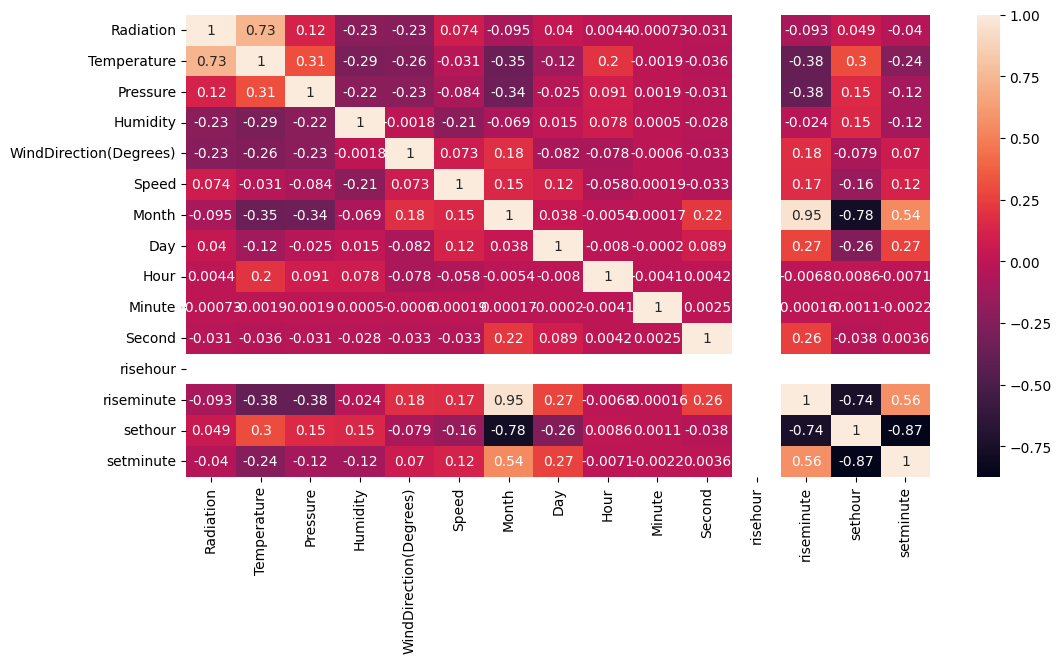

In [21]:
corr_matrix = df.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [22]:
df['risehour'].nunique()

1

**5) Feature Selection using SelectKBest Method**

Encoding our target variable as label type, because Select K Best method works on label type input

In [25]:
from sklearn.preprocessing import LabelEncoder
trainy = LabelEncoder().fit_transform(target)
target_cont = df['Radiation'].apply(lambda x : int(x)*100)

In [26]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)

In [27]:
best_features = SelectKBest(score_func = chi2, k =10).fit(scaled_input_features, target_cont)

scores = pd.DataFrame(best_features.scores_)
columns = pd.DataFrame(input_features.columns)

feature_score = pd.concat([columns, scores], axis = 1)
feature_score.columns = ['features', 'scores']
feature_score

,features,scores
0,Temperature,1184.093086
1,Pressure,70.203087
2,Humidity,440.375664
3,WindDirection(Degrees),516.112021
4,Speed,85.443754
5,Month,1104.313679
6,Day,448.857232
7,Hour,78.579884
8,Minute,239.282257
9,Second,199.023351


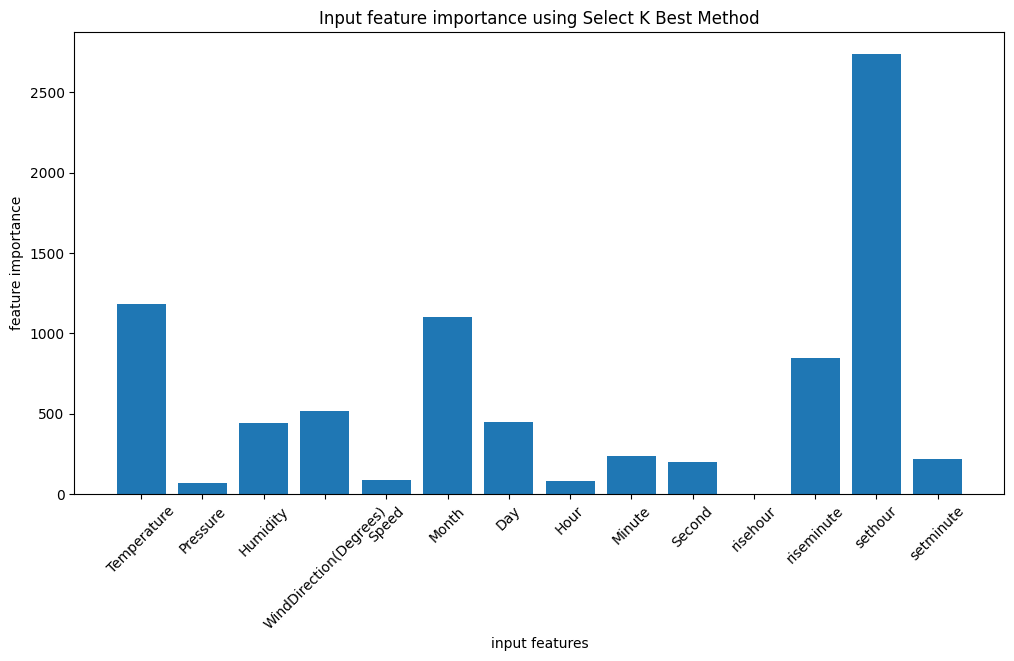

In [28]:
plt.figure(figsize = (12,6))
plt.bar('features', 'scores', data = feature_score)
plt.xticks(rotation = 45)
plt.xlabel('input features')
plt.ylabel('feature importance')
plt.title('Input feature importance using Select K Best Method')
plt.show()

**6) Feature Selection using Extra Tree Classifier**

In [29]:
model = ExtraTreesClassifier(verbose = 2, n_estimators = 10)
model.fit(scaled_input_features, target_cont)
feature_importances = pd.DataFrame(model.feature_importances_, input_features.columns, columns = ['feature_importance'])
feature_importances

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


,feature_importance
Temperature,0.118768
Pressure,0.068160
Humidity,0.086532
WindDirection(Degrees),0.132635
Speed,0.085038
Month,0.011582
Day,0.040684
Hour,0.199507
Minute,0.099563
Second,0.084316


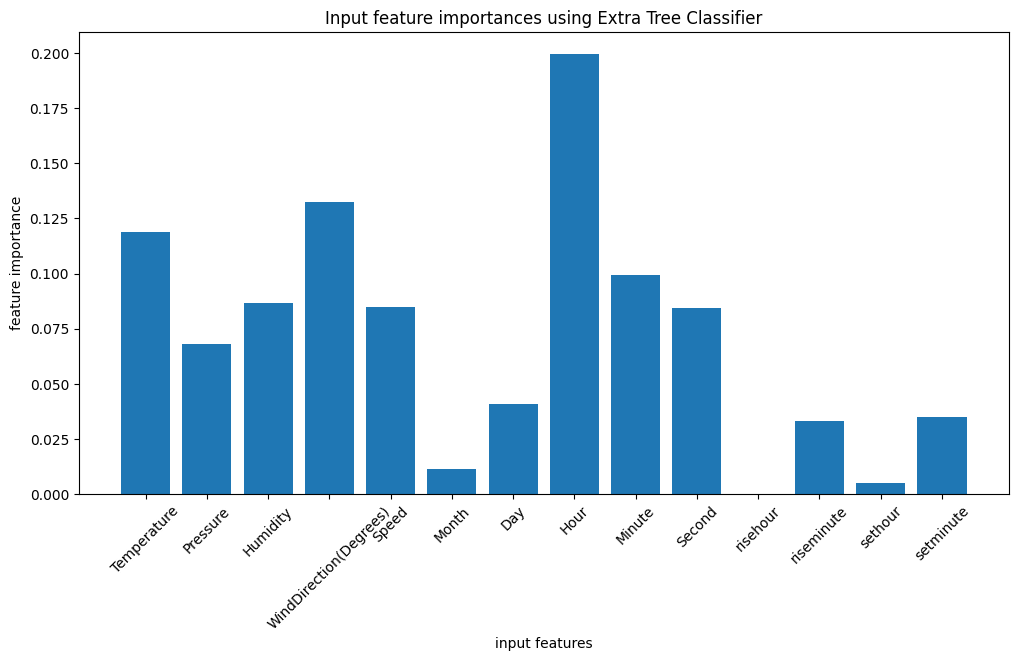

In [30]:
plt.figure(figsize = (12,6))
plt.bar(feature_importances.index, 'feature_importance', data = feature_importances)
plt.xticks(rotation = 45)
plt.xlabel('input features')
plt.ylabel('feature importance')
plt.title('Input feature importances using Extra Tree Classifier')
plt.show()

**7) Feature Engineering with BoxCox, Log, Min-Max and Standard transformation**

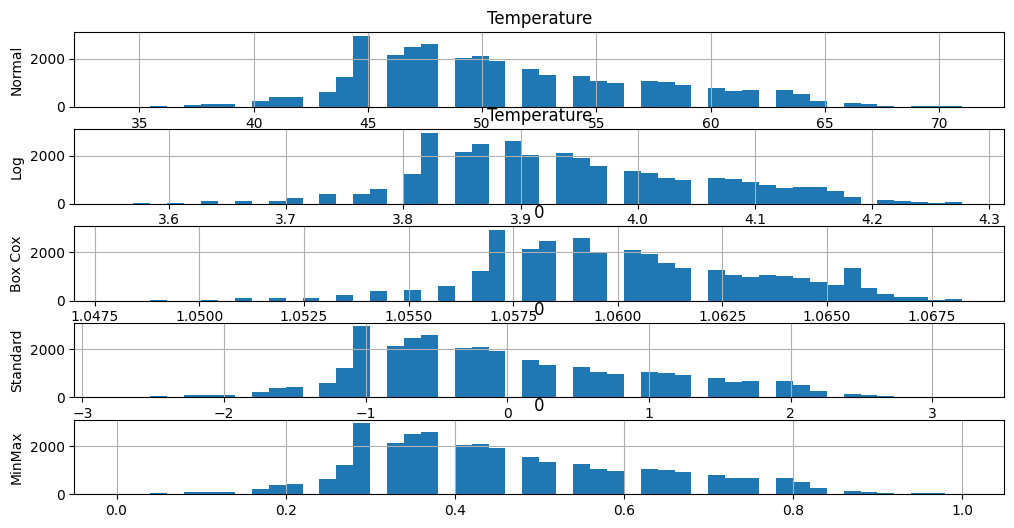

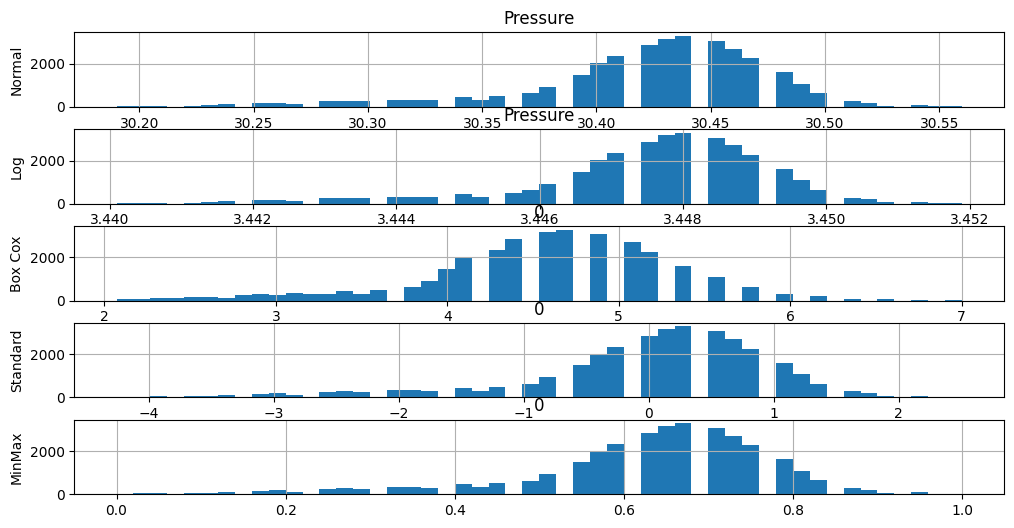

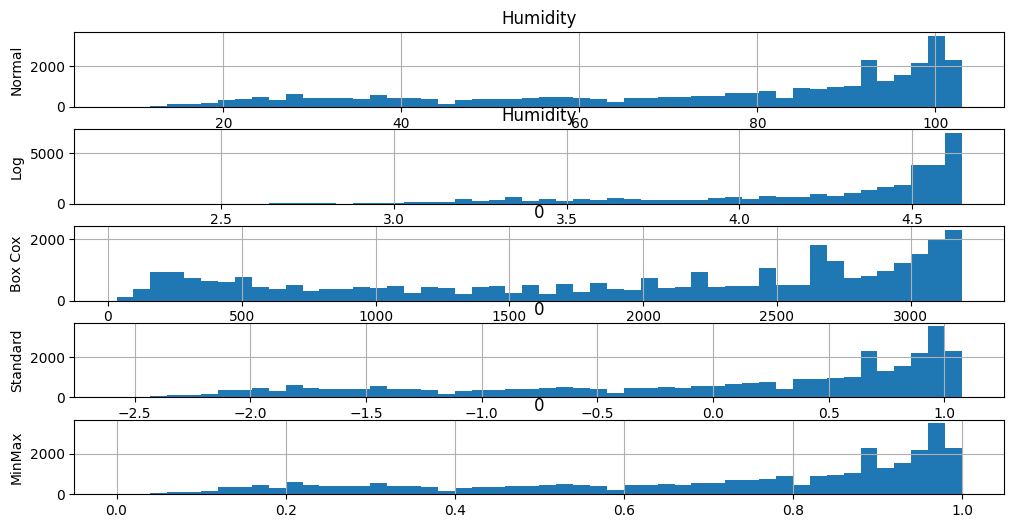

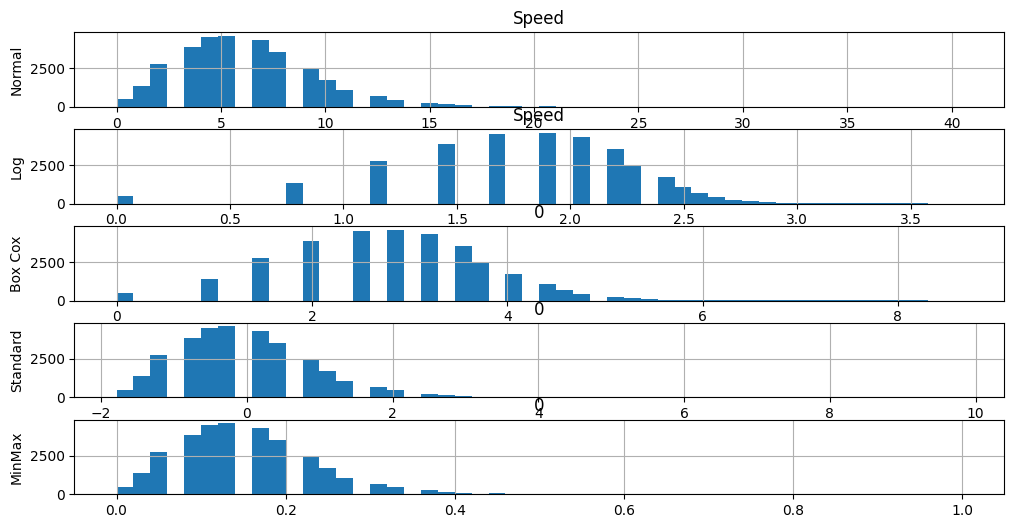

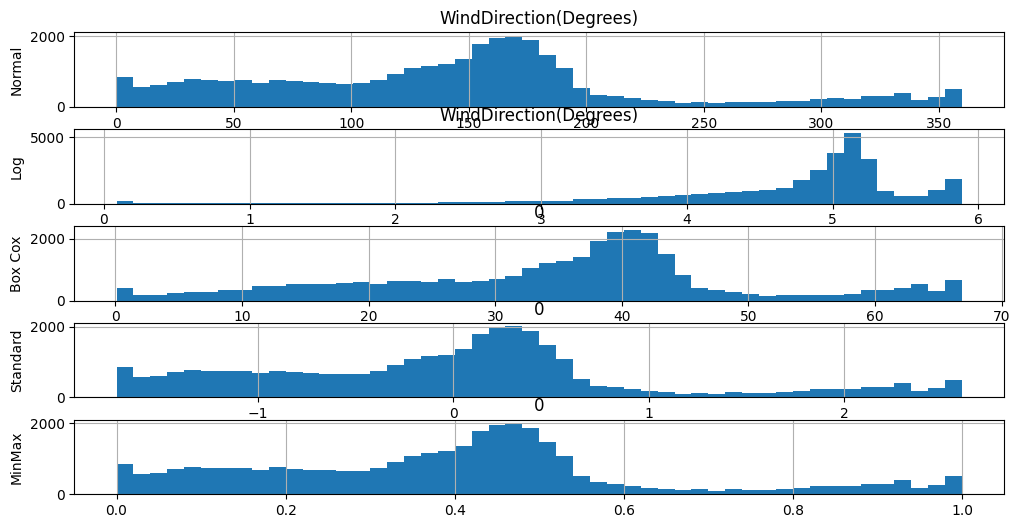

In [31]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12,6))

    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

**8) Preparing data - Standardisation and Splitting**

In [32]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
            'Speed' : (input_features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


In [33]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

**9) Prediction with XGBoost**

In [34]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)
# train the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
y_pred = model.predict(xtest)
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 81.8749


In [36]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 81.87
R2: 0.93


**10) Using MultiLayer Perceptron for prediction**

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
model = None
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [42]:
history = model.fit(xtrain, ytrain, validation_split = 0.1, epochs = 50, batch_size = 32)

Epoch 1/50
736/736 [==============================] - 3s 2ms/step - loss: 118.9504 - mse: 54035.6289 - val_loss: 75.9280 - val_mse: 21638.4863
Epoch 2/50
736/736 [==============================] - 2s 2ms/step - loss: 83.3323 - mse: 26517.8145 - val_loss: 68.3526 - val_mse: 18020.5547
Epoch 3/50
736/736 [==============================] - 1s 2ms/step - loss: 78.4923 - mse: 23411.3516 - val_loss: 63.9745 - val_mse: 15932.6318
Epoch 4/50
736/736 [==============================] - 2s 2ms/step - loss: 76.5389 - mse: 22586.8770 - val_loss: 61.3538 - val_mse: 14950.4121
Epoch 5/50
736/736 [==============================] - 1s 2ms/step - loss: 73.8941 - mse: 21294.7012 - val_loss: 59.4888 - val_mse: 14401.6182
Epoch 6/50
736/736 [==============================] - 2s 2ms/step - loss: 71.9655 - mse: 20430.8750 - val_loss: 55.8325 - val_mse: 12943.5752
Epoch 7/50
736/736 [==============================] - 2s 2ms/step - loss: 71.0956 - mse: 19795.2402 - val_loss: 54.9230 - val_mse: 12781.3096
Epoch

In [43]:
history.history

{'loss': [118.95035552978516,
  83.33232879638672,
  78.49234771728516,
  76.53892517089844,
  73.89408111572266,
  71.96551513671875,
  71.0955581665039,
  68.89927673339844,
  69.48131561279297,
  66.51090240478516,
  65.65123748779297,
  65.41917419433594,
  64.76644897460938,
  65.24601745605469,
  64.02706146240234,
  63.87580108642578,
  64.02014923095703,
  62.730892181396484,
  62.64921188354492,
  62.3079719543457,
  61.88420867919922,
  62.10811233520508,
  62.304710388183594,
  62.021358489990234,
  61.28506851196289,
  61.228515625,
  60.780399322509766,
  61.664512634277344,
  60.519142150878906,
  60.7703857421875,
  59.9461784362793,
  60.44153594970703,
  59.93280029296875,
  59.729347229003906,
  59.67641067504883,
  59.260215759277344,
  58.72578811645508,
  59.96399688720703,
  59.48923873901367,
  59.359519958496094,
  59.03977966308594,
  59.011070251464844,
  59.13869857788086,
  58.139915466308594,
  58.23111343383789,
  58.46074295043945,
  58.60212707519531,
  

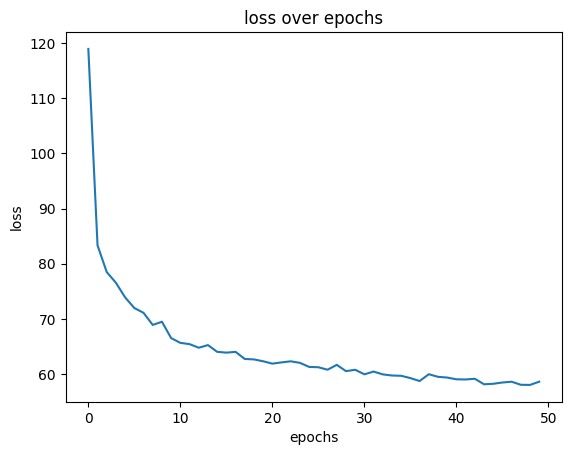

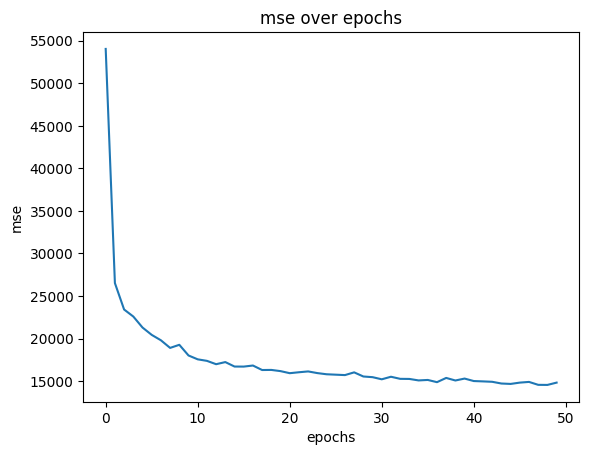

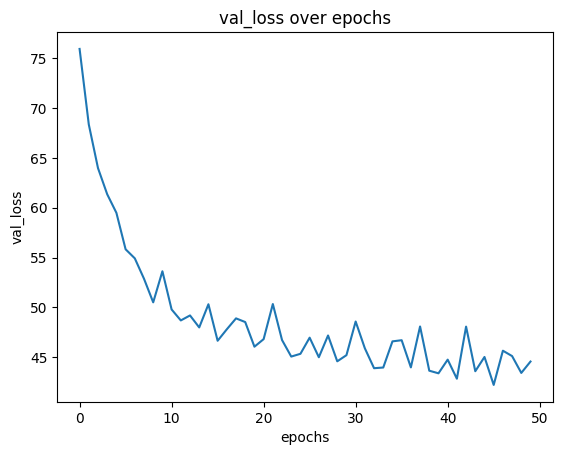

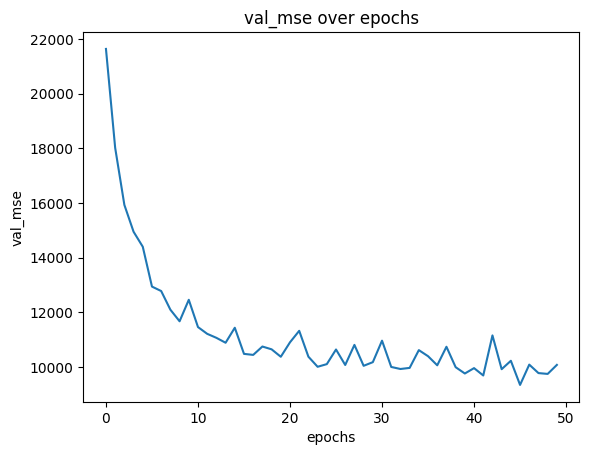

In [44]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [45]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 [==============================] - 0s 1ms/step - loss: 42.6808 - mse: 9703.2197
Mean absolute error:  42.680789947509766


In [46]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 [==============================] - 0s 1ms/step


42.680791766434204